<a href="https://colab.research.google.com/github/tamakoma1129/Synthesizer-Sound-Classification-with-SVM/blob/main/Synth%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SVMでの実装

Accuracy:  0.5303030303030303
Accuracy:  0.553030303030303
Accuracy:  0.4772727272727273
Accuracy:  0.5454545454545454
Accuracy:  0.5833333333333334
Accuracy:  0.5681818181818182
Accuracy:  0.553030303030303
Accuracy:  0.5454545454545454
Accuracy:  0.5
Accuracy:  0.5
Accuracy:  0.5151515151515151
Accuracy:  0.5303030303030303
Accuracy:  0.5378787878787878
Accuracy:  0.5303030303030303
Accuracy:  0.45454545454545453
Accuracy:  0.4772727272727273
Accuracy:  0.5757575757575758
Accuracy:  0.5378787878787878
Accuracy:  0.5
Accuracy:  0.5378787878787878
Accuracy:  0.5303030303030303
Accuracy:  0.5151515151515151
Accuracy:  0.5833333333333334
Accuracy:  0.553030303030303
Accuracy:  0.5681818181818182
Accuracy:  0.49242424242424243
Accuracy:  0.5151515151515151
Accuracy:  0.6060606060606061
Accuracy:  0.553030303030303
Accuracy:  0.5075757575757576
Accuracy:  0.4772727272727273
Accuracy:  0.5681818181818182
Accuracy:  0.5606060606060606
Accuracy:  0.5378787878787878
Accuracy:  0.59090909090909

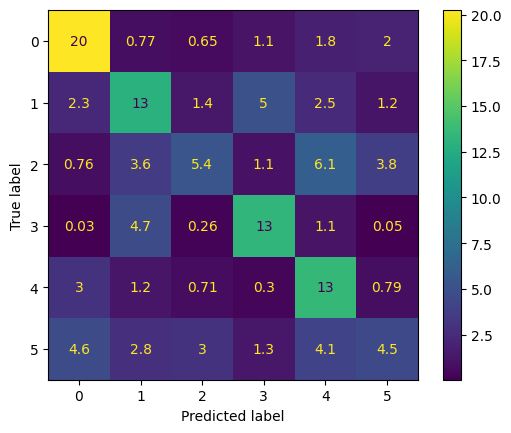

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [ ]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = svm.SVC()
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1

## 決定木での実装

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.02439024 0.07317073 0.31707317 0.04878049 0.12195122 0.41463415]
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.02439024 0.07317073 0.31707317 0.04878049 0.12195122 0.41463415]
 [0.         0.03125    0.03125    0.9375     0.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.         1.         0.         0.         0.         0.        ]
 [0.03333333 0.61666667 0.08333333 0.15       0.05       0.06666667]
 [0.         0.25925926 0.14814815 0.51851852 0.03703704 0.03703704]
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.03333333 0.61666667 0.08333333 0.15       0.05       0.06666667]
 [0.02439024 0.07317073 0.31707317 0.04878049 0.12195122 0.41463415]
 [

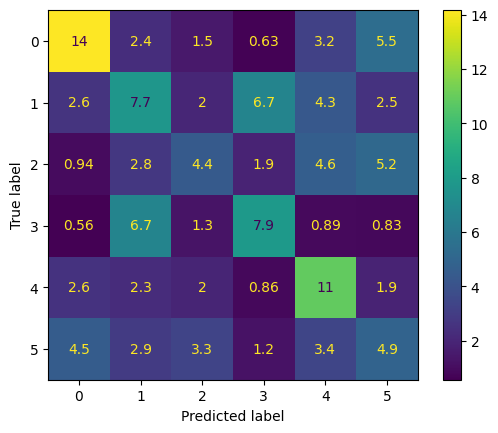

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [ ]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = DecisionTreeClassifier(max_depth=5)
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)
  # 各ジャンルに適している確率を得ます
  y_proba = model.predict_proba(X_test)
  print(y_proba,"○○が各ジャンルに適している確率")

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1

## ランダムフォレスト

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [0.         0.01       0.72       0.         0.1        0.17      ]
 [0.08133333 0.665      0.08       0.03       0.04       0.10366667]
 [0.         0.22166667 0.08333333 0.605      0.06       0.03      ]
 [0.14916667 0.06       0.32       0.01       0.07       0.39083333]
 [0.1975     0.25666667 0.13333333 0.05       0.22416667 0.13833333]
 [0.09       0.20766667 0.10333333 0.349      0.14       0.11      ]
 [0.978      0.004      0.         0.         0.         0.018     ]
 [0.         0.3625     0.06       0.47416667 0.03333333 0.07      ]
 [0.06833333 0.34083333 0.14       0.2        0.085      0.16583333]
 [0.064      0.04833333 0.245      0.11       0.34266667 0.19      ]
 [0.39833333 0.255      0.07       0.08       0.08       0.11666667]
 [0.02333333 0.32233333 0.1425     0.38516667 0.03       0.09666667]
 [0.004      0.0365     0.07       0.1275     0.045      0.717     ]
 [0.015      0.04833333 0.184      0.03       0.67266667 0.05      ]
 [

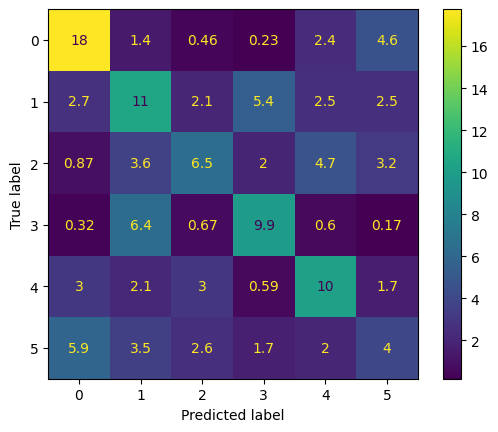

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [ ]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = RandomForestClassifier()
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)
  # 各ジャンルに適している確率を得ます
  y_proba = model.predict_proba(X_test)
  print(y_proba,"○○が各ジャンルに適している確率")

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1

## GBDT

In [ ]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data" # フォルダのパスを指定 (e.g., "/content/drive/My Drive/A/data/")
def load_and_pad(file_path):    # paddingする関数
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []



# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# データとラベルを訓練データとテストデータに分割します
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

# SVMのモデルを作成し、訓練データで学習します
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3)
score = cross_val_score(model,X_train,y_train)
print(score)

[0.48113208 0.41509434 0.39622642 0.45714286 0.39047619]


## k-近傍法

In [ ]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data" # フォルダのパスを指定 (e.g., "/content/drive/My Drive/A/data/")
def load_and_pad(file_path):    # paddingする関数
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []



# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# データとラベルを訓練データとテストデータに分割します
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

# k-近傍法のモデルを作成し、訓練データで学習します
max=[0,0]
min=[100,0]
for i in range(3,50):
  model = KNeighborsClassifier(n_neighbors=i)
  score = cross_val_score(model,X_train,y_train)
  print(score)
  if max[0] < score.mean():
    max[0]=score.mean()
    max[1]=i
  if min[0] > score.mean():
    min[0]=score.mean()
    min[1]=i
  print(f"{i}回目の平均:",score.mean())
print(f"Max:k={max[1]}の時{max[0]}")
print(f"Min:k={min[1]}の時{min[0]}")

[0.43396226 0.39622642 0.52830189 0.46666667 0.5047619 ]
3回目の平均: 0.4659838274932615
[0.46226415 0.43396226 0.53773585 0.46666667 0.5047619 ]
4回目の平均: 0.481078167115903
[0.46226415 0.47169811 0.56603774 0.48571429 0.51428571]
5回目の平均: 0.5
[0.48113208 0.48113208 0.52830189 0.47619048 0.51428571]
6回目の平均: 0.4962084456424079
[0.46226415 0.44339623 0.55660377 0.45714286 0.53333333]
7回目の平均: 0.49054806828391734
[0.45283019 0.4245283  0.55660377 0.43809524 0.52380952]
8回目の平均: 0.4791734052111411
[0.47169811 0.44339623 0.51886792 0.44761905 0.55238095]
9回目の平均: 0.4867924528301887
[0.44339623 0.45283019 0.51886792 0.42857143 0.55238095]
10回目の平均: 0.4792093441150045
[0.45283019 0.44339623 0.5        0.45714286 0.56190476]
11回目の平均: 0.48305480682839175
[0.48113208 0.43396226 0.51886792 0.45714286 0.56190476]
12回目の平均: 0.4906019766397125
[0.48113208 0.44339623 0.5        0.43809524 0.55238095]
13回目の平均: 0.4830008984725966
[0.48113208 0.4245283  0.50943396 0.43809524 0.55238095]
14回目の平均: 0.4811141060197664
[

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [0.125 0.125 0.5   0.    0.    0.25 ]
 [0.    0.125 0.    0.125 0.75  0.   ]
 [0.    0.375 0.125 0.375 0.125 0.   ]
 [0.125 0.    0.    0.75  0.    0.125]
 [0.    0.25  0.5   0.125 0.    0.125]
 [0.125 0.125 0.    0.5   0.    0.25 ]
 [0.    0.5   0.    0.    0.25  0.25 ]
 [0.    0.25  0.125 0.5   0.    0.125]
 [0.    0.5   0.    0.5   0.    0.   ]
 [0.    0.125 0.25  0.    0.375 0.25 ]
 [1.    0.    0.    0.    0.    0.   ]
 [0.125 0.    0.    0.875 0.    0.   ]
 [0.125 0.    0.    0.375 0.25  0.25 ]
 [0.125 0.    0.    0.75  0.    0.125]
 [1.    0.    0.    0.    0.    0.   ]
 [0.    0.375 0.375 0.125 0.    0.125]
 [0.75  0.    0.    0.    0.25  0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.625 0.    0.375 0.    0.   ]
 [0.125 0.75  0.    0.125 0.    0.   ]
 [0.125 0.125 0.25  0.    0.    0.5  ]
 [0.    0.5   0.    0.125 0.125 0.25 ]
 [0.    0.    0.375 0.    0.375 0.25 ]
 [0.    0.    0.125 0.    0.25  0.625]
 [0.25  0.125 0.125 0.375 0.    

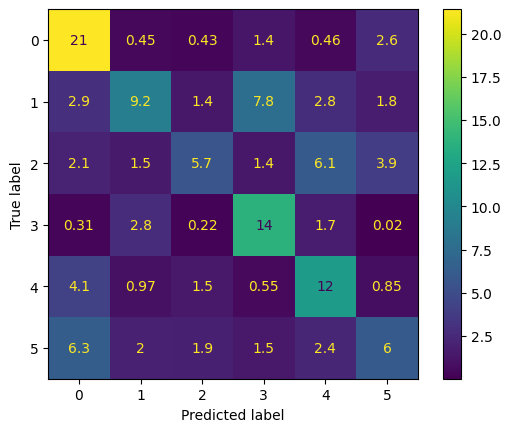

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [ ]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsClassifier

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = KNeighborsClassifier(n_neighbors=8)
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)
  # 各ジャンルに適している確率を得ます
  y_proba = model.predict_proba(X_test)
  print(y_proba,"○○が各ジャンルに適している確率")

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1

## 学習モデルを保存する

In [4]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.neighbors import KNeighborsClassifier

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# モデルの学習
model = KNeighborsClassifier(n_neighbors=8)
model.fit(data, labels)

# モデルを保存
joblib.dump(model, '/content/drive/MyDrive/シンセ音源分類ソフト作成/model.pkl')

# LabelEncoderを保存
joblib.dump(encoder, '/content/drive/MyDrive/シンセ音源分類ソフト作成/encoder.pkl')

['/content/drive/MyDrive/シンセ音源分類ソフト作成/encoder.pkl']